In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import matplotlib as mpl
import matplotlib.font_manager as fm

# 관광지의 요소에 따른 방문자 수 차이

## 한글 폰트 설정

In [2]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 사용할 폰트 설정

# 기본적인 폰트 설정(옵션)
plt.rcParams['font.size'] = 12            # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

NameError: ignored

## A. 전국관광지정보표준데이터 (공공데이터포털)

In [3]:
# "전국관광지정보표준데이터.csv" 불러오기

whole_tour = pd.read_csv("전국관광지정보표준데이터.csv", encoding = 'cp949')
whole_tour.head(1)

NameError: ignored

### (0) 데이터 전처리

#### (0-1) 해당 데이터셋에 '세종'이 없음을 확인

In [ ]:
# '소재지도로명주소' 컬럼에 '세종' 키워드가 있는지 확인
contains_세종_도로명주소 = whole_tour['소재지도로명주소'].str.contains('세종')

# '소재지지번주소' 컬럼에 '세종' 키워드가 있는지 확인
contains_세종_지번주소 = whole_tour['소재지지번주소'].str.contains('세종')

# '소재지도로명주소' 또는 '소재지지번주소' 컬럼 중 하나라도 '세종' 키워드가 들어간 행 선택
result = whole_tour[contains_세종_도로명주소 | contains_세종_지번주소]

# '결과 확인
print(result[['소재지도로명주소', '소재지지번주소']])

#### (0-2) 필요 없는 컬럼 삭제하기

In [ ]:
whole_tour = whole_tour.drop(columns = ['관광지구분','면적','지정일자','관리기관전화번호','관리기관명','제공기관코드','제공기관명','데이터기준일자'], axis=1)
whole_tour.head(2)

#### (0-3) '시도명' & '시군구명' 컬럼으로 변환

In [ ]:
# '소재지도로명주소'or'소재지지번주소' 중 하나라도 값이 있으면, 해당 값을 '시도명'과 '시군구명'으로 설정
whole_tour['시도명'] = whole_tour['소재지도로명주소'].str.split(' ', n=1).str[0].fillna(whole_tour['소재지지번주소'].str.split(' ', n=1).str[0])
whole_tour['시군구명'] = whole_tour['소재지도로명주소'].str.split(' ', n=2).str[1].fillna(whole_tour['소재지지번주소'].str.split(' ', n=2).str[1])

# 기존의 '소재지도로명주소'와 '소재지지번주소' 컬럼은 삭제
whole_tour.drop(['소재지도로명주소', '소재지지번주소'], axis=1, inplace=True)

# '시도명'과 '시군구명' 컬럼을 가장 앞쪽 열로 위치
whole_tour.insert(0, '시군구명', whole_tour.pop('시군구명'))
whole_tour.insert(0, '시도명', whole_tour.pop('시도명'))

#### (0-4) '시도명' 값 정리하기

In [ ]:
whole_tour['시도명'].unique()

##### ① '시도명' 중 동일한 지역 일치시키기

In [ ]:
whole_tour['시도명'].replace({
    '강원도': '강원특별자치도',
    '전남': '전라남도',
    '경남': '경상남도'
}, inplace=True)

##### ② '경기도 연천군' 정리하기

In [ ]:
whole_tour.loc[whole_tour['시도명'].str.contains('경기도'), '시도명'] = '경기도'
whole_tour.loc[whole_tour['시도명'].str.contains('연천군'), '시군구명'] = '연천군'

##### ③ '경기도 안성시' 정리하기

In [ ]:
whole_tour.loc[whole_tour['시도명'].str.contains('안성시', na=False), '시도명'] = '경기도'
whole_tour.loc[whole_tour['시도명'].str.contains('안성시', na=False), '시군구명'] = '안성시'

In [ ]:
whole_tour['시도명'].unique()  # '세종' 없어서 총 16개

#### ※ 데이터 전처리 후 확인

In [ ]:
whole_tour.tail(2)

### (1) '공공편익시설정보' 컬럼

In [ ]:
# '공공편익시설정보' 컬럼 확인하기

# whole_tour['공공편익시설정보'].unique()

In [ ]:
# '공공편익시설정보' 컬럼에 있는 모든 키워드 확인

whole_tour['공공편익시설정보'].str.split('+').explode().str.strip().unique()

#### (1-0) 요소들 선정 (by 언급 많이 되는 키워드 기준)

In [ ]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

In [ ]:
keywords = whole_tour['공공편익시설정보'].str.split('+').explode().str.strip()

In [ ]:
# 많이 언급되는 키워드를 수치로 확인하기
keywords.value_counts(sort=True, ascending=False)

In [ ]:
# 폰트 경로 설정
font_path = r'C:/Windows/Fonts/malgun.ttf'

# 키워드 빈도수 계산
keyword_counts = keywords.value_counts()

# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### ※ 요소들 선정 (10개)
 → '화장실', '주차장', '관리사무소', '안내소',  '샤워장', '광장', '수유실', '휴게/쉼터', '공원', '카페/커피'
- c.f.) 도로, 배수시설 등 관광지와 상관없는 일반적인 요소들은 제외

#### (1-1) '화장실' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '화장실'이라는 키워드 포함 여부
def has_toilet(info):
    return 1 if '화장실' in info else 0

# '화장실' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(6, '화장실', 0)

# '공공편익시설정보' 컬럼을 기반으로 '화장실' 컬럼의 값 입력
whole_tour['화장실'] = whole_tour['공공편익시설정보'].apply(has_toilet)

#### (1-2) '주차장' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '주차장'이라는 키워드 포함 여부
def has_parking(info):
    return 1 if '주차장' in info else 0

# '주차장' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(7, '주차장', 0)

# '공공편익시설정보' 컬럼을 기반으로 '주차장' 컬럼의 값 입력
whole_tour['주차장'] = whole_tour['공공편익시설정보'].apply(has_parking)

#### (1-3) '관리사무소' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '관리'or'사무'이라는 키워드 포함 여부
def has_office(info):
    return 1 if ('관리' in info) or ('사무' in info) else 0

# '관리사무소' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(8, '관리사무소', 0)

# '공공편익시설정보' 컬럼을 기반으로 '관리사무소' 컬럼의 값 입력
whole_tour['관리사무소'] = whole_tour['공공편익시설정보'].apply(has_office)

#### (1-4) '안내소' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '안내'이라는 키워드 포함 여부
def has_guide(info):
    return 1 if '안내' in info else 0

# '안내소' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(9, '안내소', 0)

# '공공편익시설정보' 컬럼을 기반으로 '안내소' 컬럼의 값 입력
whole_tour['안내소'] = whole_tour['공공편익시설정보'].apply(has_guide)

#### (1-5) '샤워장' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '샤워장'이라는 키워드 포함 여부
def has_shower(info):
    return 1 if '샤워장' in info else 0

# '샤워장' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(10, '샤워장', 0)

# '공공편익시설정보' 컬럼을 기반으로 '샤워장' 컬럼의 값 입력
whole_tour['샤워장'] = whole_tour['공공편익시설정보'].apply(has_shower)

#### (1-6) '광장' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '광장'이라는 키워드 포함 여부
def has_plaza(info):
    return 1 if '광장' in info else 0

# '광장' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(11, '광장', 0)

# '공공편익시설정보' 컬럼을 기반으로 '광장' 컬럼의 값 입력
whole_tour['광장'] = whole_tour['공공편익시설정보'].apply(has_plaza)

#### (1-7) '수유실' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '수유실'이라는 키워드 포함 여부
def has_feeding(info):
    return 1 if '수유실' in info else 0

# '수유실' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(12, '수유실', 0)

# '공공편익시설정보' 컬럼을 기반으로 '수유실' 컬럼의 값 입력
whole_tour['수유실'] = whole_tour['공공편익시설정보'].apply(has_feeding)

#### (1-8) '휴게/쉼터' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '휴게'or'쉼터'라는 키워드 포함 여부
def has_rest(info):
    return 1 if ('휴게' in info) or ('쉼터' in info) else 0

# '휴게/쉼터' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(13, '휴게/쉼터', 0)

# '공공편익시설정보' 컬럼을 기반으로 '휴게/쉼터' 컬럼의 값 입력
whole_tour['휴게/쉼터'] = whole_tour['공공편익시설정보'].apply(has_rest)

#### (1-9) '공원' 컬럼 추가

In [4]:
# '공공편익시설정보' 컬럼 안에 '공원'이라는 키워드 포함 여부
def has_park(info):
    return 1 if '공원' in info else 0

# '공원' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(14, '공원', 0)

# '공공편익시설정보' 컬럼을 기반으로 '공원' 컬럼의 값 입력
whole_tour['공원'] = whole_tour['공공편익시설정보'].apply(has_park)

NameError: ignored

#### (1-10) '카페/커피' 컬럼 추가

In [ ]:
# '공공편익시설정보' 컬럼 안에 '카페'or'커피'이라는 키워드 포함 여부
def has_coffee(info):
    return 1 if ('카페' in info) or ('커피' in info) else 0

# '카페/커피' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(15, '카페/커피', 0)

# '공공편익시설정보' 컬럼을 기반으로 '카페/커피' 컬럼의 값 입력
whole_tour['카페/커피'] = whole_tour['공공편익시설정보'].apply(has_coffee)

#### ※ 추가한 컬럼들 확인

In [ ]:
whole_tour.iloc[:, 6:16].tail()

### (2) '숙박시설정보' 컬럼

In [ ]:
# '숙박시설정보' 컬럼 확인하기
# whole_tour['숙박시설정보'].unique()

In [ ]:
# '숙박시설정보' 컬럼을 유무 값으로 대체
whole_tour['숙박시설정보'] = whole_tour['숙박시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

### (3) '운동및오락시설정보' 컬럼

In [ ]:
# '운동및오락시설정보' 컬럼 확인하기
# whole_tour['운동및오락시설정보'].unique()

In [ ]:
# '운동및오락시설정보' 컬럼을 유무 값으로 대체
whole_tour['운동및오락시설정보'] = whole_tour['운동및오락시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

### (4) '휴양및문화시설정보' 컬럼

In [ ]:
# '휴양및문화시설정보' 컬럼 확인하기
# whole_tour['휴양및문화시설정보'].unique()

In [ ]:
# '휴양및문화시설정보' 컬럼을 유무 값으로 대체
whole_tour['휴양및문화시설정보'] = whole_tour['휴양및문화시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

### (5) '접객시설정보' 컬럼

In [ ]:
# '접객시설정보' 컬럼 확인하기
# whole_tour['접객시설정보'].unique()

In [ ]:
# '접객시설정보' 컬럼을 유무 값으로 대체
whole_tour['접객시설정보'] = whole_tour['접객시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

### (6) '지원시설정보' 컬럼

In [ ]:
# '지원시설정보' 컬럼 확인하기
# whole_tour['지원시설정보'].unique()

In [ ]:
# '지원시설정보' 컬럼을 유무 값으로 대체
whole_tour['지원시설정보'] = whole_tour['지원시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

#### ※ 최종 확인

In [ ]:
whole_tour  # 860 rows × 24 columns
            # 다양한 요소들 컬럼 → 총 15개

## B. 주요관광지점 입장객 데이터 (관광지식정보시스템)

In [ ]:
# "주요관광지점 입장객 (2004-2023).csv" 불러오기

tour_visit = pd.read_csv("주요관광지점 입장객 (2004-2023).csv", encoding = 'utf-8')
# tour_visit

### (0) 데이터 전처리

#### (0-1) '내국인' 행만 남겨두기

In [ ]:
tour_visit = tour_visit[tour_visit['내/외국인'] == '내국인']
# tour_visit

#### (0-2) 컬럼명 변경 및 정리

##### ① '내/외국인' 컬럼 삭제

In [ ]:
tour_visit = tour_visit.drop('내/외국인', axis=1)

##### ② 'Unnamed: 18' 컬럼 삭제

In [ ]:
tour_visit = tour_visit.drop('Unnamed: 18', axis=1)

##### ③ '2011년' ~ '2023년'으로 컬럼명 변경

In [ ]:
columns_to_rename = tour_visit.columns[4:]

new_column_names = [f'{year}년' for year in range(2011, 2024)]
tour_visit.rename(columns = dict(zip(columns_to_rename, new_column_names)), inplace=True)

##### ④ 기타 컬럼명 변경

In [ ]:
# '시도' → '시도명'으로 변경
tour_visit.rename(columns={'시도':'시도명'}, inplace=True)

# '군구' → '시군구명'으로 변경
tour_visit.rename(columns={'군구':'시군구명'}, inplace=True)

# '관광지' → '관광지명'으로 변경
tour_visit.rename(columns={'관광지':'관광지명'}, inplace=True)

# '총계' → '총 방문자 수'로 변경
tour_visit.rename(columns={'총계':'총 방문자 수'}, inplace=True)

##### ⑤ '2011년' ~ '2023년' 컬럼명 삭제

In [ ]:
tour_visit = tour_visit.drop(tour_visit.columns[4:17], axis=1)

#### (0-3) '시도명' 값 일치시키기

In [ ]:
# whole_tour의 '시도명' 값 확인
whole_tour['시도명'].unique()

In [ ]:
# tour_visit의 '시도명' 값 확인
tour_visit['시도명'].unique()

In [ ]:
# tour_visit의 '시도명' 값 변경
tour_visit['시도명'] = tour_visit['시도명'].replace({'강원도':'강원특별자치도'})

#### (0-4) '문자형' → '정수형'으로 변환

In [ ]:
# tour_visit의 데이터타입 확인
# tour_visit.dtypes

In [ ]:
# '총 방문자 수' 컬럼
columns_to_convert = tour_visit.columns[3]

# '콤마(,) 제거하고 숫자형으로 변환
tour_visit[columns_to_convert] = tour_visit[columns_to_convert].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

# NaN 값을 0으로 처리
tour_visit.fillna(0, inplace=True)

# 정수형으로 변환
tour_visit[columns_to_convert] = tour_visit[columns_to_convert].astype('int64')

In [ ]:
tour_visit.dtypes

#### (0-5) '총 방문자 수' = 0 인 값 삭제

In [ ]:
tour_visit = tour_visit[tour_visit['총 방문자 수'] != 0]

#### ※ 최종 확인

In [ ]:
tour_visit  # 4432 rows × 4 columns

#### ※ csv 파일로 저장

In [ ]:
# tour_visit.to_csv('tour_visit.csv', index=False)

## C. 데이터 병합

### (1) "A. 전국관광지정보표준데이터"에 "B. 주요관광지점 입장객 데이터"를 병합

#### (1-1) '시도명' 일치하는지 확인

In [ ]:
# whole_tour의 '시도명' 값 확인
print("(A) whole_tour의 '시도명': ")
print(sorted(whole_tour['시도명'].unique()))  # '세종특별자치시' 없음

# tour_visit의 '시도명' 값 확인
print("\n(B) tour_visit의 '시도명': ")
print(sorted(tour_visit['시도명'].unique()))

#### (1-2) '시도명', '시군구명', '관광지명' 모두 일치하는 행들을 병합

In [ ]:
# '시도명', '시군구명', '관광지명' 모두 일치하는 행들을 추출하여 병합
AB_merged_df = whole_tour.merge(tour_visit, on = ['시도명', '시군구명', '관광지명'], how = 'inner')

# '총 방문자 수'로 내림차순
AB_merged_df = AB_merged_df.sort_values(by='총 방문자 수', ascending=False)

AB_merged_df  # 총 245개 관광지

# 참고) '관광지명'만 기준으로 할 경우, 관광지명은 일치하지만 다른 지역인 경우가 있음.
        # ex 1. 송도해수욕장 (부산광역시 서구 & 경상북도 포항시)
        # ex 2. 갓바위 (전라남도 목포시 & 경상북도 경산시)

## D. 가설 검정

### (1) '화장실' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
from scipy.stats import pearsonr

In [ ]:
# '화장실' & '총 방문자 수' 컬럼 선택
selected_cols = ['화장실', '총 방문자 수']
toilet_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(toilet_df['화장실'], toilet_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '화장실 있는 관광지'와 '화장실 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '화장실 있는 관광지'와 '화장실 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
from scipy.stats import ttest_ind
from scipy import stats

In [ ]:
# '화장실 있는 관광지'와 '화장실 없는 관광지'를 분리하여 데이터프레임 생성
has_toilet_df = AB_merged_df[AB_merged_df['화장실'] == 1]
no_toilet_df = AB_merged_df[AB_merged_df['화장실'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("화장실 있는 관광지:")
print(has_toilet_df['총 방문자 수'].describe())

print("\n화장실 없는 관광지:")
print(no_toilet_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_toilet_df['log_총 방문자 수'] = has_toilet_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_toilet_df['log_총 방문자 수'] = no_toilet_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_toilet_df['log_총 방문자 수'], no_toilet_df['log_총 방문자 수']], labels=['화장실 있는 관광지','화장실 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# c.f.) 로그 변환 없이 Box Plot 그리기

# plt.figure(figsize=(8, 6))
# plt.boxplot([has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수']], labels=['화장실 있는 관광지', '화장실 없는 관광지'])
# plt.ylabel('총 방문자 수')
# plt.title("'총 방문자 수' 분포 비교")
# plt.grid(True)
# plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'화장실 있는 관광지 개수 : {len(has_toilet_df)}')
print(f'화장실 없는 관광지 개수 : {len(no_toilet_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'화장실 있는 관광지'와 '화장실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'화장실 있는 관광지'와 '화장실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (2) '주차장' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
# '주차장' & '총 방문자 수' 컬럼 선택
selected_cols = ['주차장', '총 방문자 수']
parking_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(parking_df['주차장'], parking_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [5]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 없다.")

NameError: ignored

#### ② t-검정 (t-test)
- H0 : '주차장 있는 관광지'와 '주차장 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '주차장 있는 관광지'와 '주차장 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
# '주차장 있는 관광지'와 '주차장 없는 관광지'를 분리하여 데이터프레임 생성
has_parking_df = AB_merged_df[AB_merged_df['주차장'] == 1]
no_parking_df = AB_merged_df[AB_merged_df['주차장'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("주차장 있는 관광지:")
print(has_parking_df['총 방문자 수'].describe())

print("\n주차장 없는 관광지:")
print(no_parking_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_parking_df['log_총 방문자 수'] = has_parking_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_parking_df['log_총 방문자 수'] = no_parking_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_parking_df['log_총 방문자 수'], no_parking_df['log_총 방문자 수']], labels=['주차장 있는 관광지','주차장 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'주차장 있는 관광지 개수 : {len(has_parking_df)}')
print(f'주차장 없는 관광지 개수 : {len(no_parking_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'주차장 있는 관광지'와 '주차장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'주차장 있는 관광지'와 '주차장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (3) '관리사무소' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
# '관리사무소' & '총 방문자 수' 컬럼 선택
selected_cols = ['관리사무소', '총 방문자 수']
office_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(office_df['관리사무소'], office_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
# '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'를 분리하여 데이터프레임 생성
has_office_df = AB_merged_df[AB_merged_df['관리사무소'] == 1]
no_office_df = AB_merged_df[AB_merged_df['관리사무소'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("관리사무소 있는 관광지:")
print(has_office_df['총 방문자 수'].describe())

print("\n관리사무소 없는 관광지:")
print(no_office_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_office_df['log_총 방문자 수'] = has_office_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_office_df['log_총 방문자 수'] = no_office_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_office_df['log_총 방문자 수'], no_office_df['log_총 방문자 수']], labels=['관리사무소 있는 관광지','관리사무소 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'관리사무소 있는 관광지 개수 : {len(has_office_df)}')
print(f'관리사무소 없는 관광지 개수 : {len(no_office_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (4) '안내소' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['안내소', '총 방문자 수']
guide_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(guide_df['안내소'], guide_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '안내소 있는 관광지'와 '안내소 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '안내소 있는 관광지'와 '안내소 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_guide_df = AB_merged_df[AB_merged_df['안내소'] == 1]
no_guide_df = AB_merged_df[AB_merged_df['안내소'] == 0]

In [6]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("안내소 있는 관광지:")
print(has_guide_df['총 방문자 수'].describe())

print("\n안내소 없는 관광지:")
print(no_guide_df['총 방문자 수'].describe())

안내소 있는 관광지:


NameError: ignored

In [ ]:
# '총 방문자 수' 로그 변환
has_guide_df['log_총 방문자 수'] = has_guide_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_guide_df['log_총 방문자 수'] = no_guide_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_guide_df['log_총 방문자 수'], no_guide_df['log_총 방문자 수']], labels=['안내소 있는 관광지','안내소 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'안내소 있는 관광지 개수 : {len(has_guide_df)}')
print(f'안내소 없는 관광지 개수 : {len(no_guide_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'안내소 있는 관광지'와 '안내소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'안내소 있는 관광지'와 '안내소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (5) '샤워장' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['샤워장', '총 방문자 수']
shower_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(shower_df['샤워장'], shower_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '샤워장 있는 관광지'와 '샤워장 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '샤워장 있는 관광지'와 '샤워장 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_shower_df = AB_merged_df[AB_merged_df['샤워장'] == 1]
no_shower_df = AB_merged_df[AB_merged_df['샤워장'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("샤워장 있는 관광지:")
print(has_shower_df['총 방문자 수'].describe())

print("\n샤워장 없는 관광지:")
print(no_shower_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_shower_df['log_총 방문자 수'] = has_shower_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_shower_df['log_총 방문자 수'] = no_shower_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_shower_df['log_총 방문자 수'], no_shower_df['log_총 방문자 수']], labels=['샤워장 있는 관광지','샤워장 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'샤워장 있는 관광지 개수 : {len(has_shower_df)}')
print(f'샤워장 없는 관광지 개수 : {len(no_shower_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'샤워장 있는 관광지'와 '샤워장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'샤워장 있는 관광지'와 '샤워장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


#### ③ Mann-Whitney U검정
- H0 : '샤워장 있는 관광지'와 '샤워장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.
- H1 : '샤워장 있는 관광지'와 '샤워장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
statistic, p_value = mannwhitneyu(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'])

print("검정 통계량:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n 두 집단의 중앙값은 유의미하게 다르다.")
else:
    print("\n 두 집단의 중앙값은 유의미하게 다르지 않다.")

### (6) '광장' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['광장', '총 방문자 수']
plaza_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(plaza_df['광장'], plaza_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_plaza_df = AB_merged_df[AB_merged_df['광장'] == 1]
no_plaza_df = AB_merged_df[AB_merged_df['광장'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("광장 있는 관광지:")
print(has_plaza_df['총 방문자 수'].describe())

print("\n광장 없는 관광지:")
print(no_plaza_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_plaza_df['log_총 방문자 수'] = has_plaza_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_plaza_df['log_총 방문자 수'] = no_plaza_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_plaza_df['log_총 방문자 수'], no_plaza_df['log_총 방문자 수']], labels=['광장 있는 관광지','광장 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'광장 있는 관광지 개수 : {len(has_plaza_df)}')
print(f'광장 없는 관광지 개수 : {len(no_plaza_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'광장 있는 관광지'와 '광장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'광장 있는 관광지'와 '광장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

#### ③ Mann-Whitney U검정
- H0 : '광장 있는 관광지'와 '광장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.
- H1 : '광장 있는 관광지'와 '광장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
statistic, p_value = mannwhitneyu(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'])

print("검정 통계량:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n 두 집단의 중앙값은 유의미하게 다르다.")
else:
    print("\n 두 집단의 중앙값은 유의미하게 다르지 않다.")

### (7) '수유실' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['수유실', '총 방문자 수']
feeding_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(feeding_df['수유실'], feeding_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '수유실 있는 관광지'와 '수유실 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '수유실 있는 관광지'와 '수유실 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_feeding_df = AB_merged_df[AB_merged_df['수유실'] == 1]
no_feeding_df = AB_merged_df[AB_merged_df['수유실'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("수유실 있는 관광지:")
print(has_feeding_df['총 방문자 수'].describe())

print("\n수유실 없는 관광지:")
print(no_feeding_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_feeding_df['log_총 방문자 수'] = has_feeding_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_feeding_df['log_총 방문자 수'] = no_feeding_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_feeding_df['log_총 방문자 수'], no_feeding_df['log_총 방문자 수']], labels=['수유실 있는 관광지','수유실 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'수유실 있는 관광지 개수 : {len(has_feeding_df)}')
print(f'수유실 없는 관광지 개수 : {len(no_feeding_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'수유실 있는 관광지'와 '수유실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'수유실 있는 관광지'와 '수유실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

#### ③ Mann-Whitney U검정
- H0 : '수유실 있는 관광지'와 '수유실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.
- H1 : '수유실 있는 관광지'와 '수유실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
statistic, p_value = mannwhitneyu(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'])

print("검정 통계량:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n 두 집단의 중앙값은 유의미하게 다르다.")
else:
    print("\n 두 집단의 중앙값은 유의미하게 다르지 않다.")

### (8) '휴게/쉼터' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['휴게/쉼터', '총 방문자 수']
rest_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(rest_df['휴게/쉼터'], rest_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_rest_df = AB_merged_df[AB_merged_df['휴게/쉼터'] == 1]
no_rest_df = AB_merged_df[AB_merged_df['휴게/쉼터'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("휴게/쉼터 있는 관광지:")
print(has_rest_df['총 방문자 수'].describe())

print("\n휴게/쉼터 없는 관광지:")
print(no_rest_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_rest_df['log_총 방문자 수'] = has_rest_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_rest_df['log_총 방문자 수'] = no_rest_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_rest_df['log_총 방문자 수'], no_rest_df['log_총 방문자 수']], labels=['휴게/쉼터 있는 관광지','휴게/쉼터 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'휴게/쉼터 있는 관광지 개수 : {len(has_rest_df)}')
print(f'휴게/쉼터 없는 관광지 개수 : {len(no_rest_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

#### ③ Mann-Whitney U검정
- H0 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.
- H1 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
statistic, p_value = mannwhitneyu(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'])

print("검정 통계량:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n 두 집단의 중앙값은 유의미하게 다르다.")
else:
    print("\n 두 집단의 중앙값은 유의미하게 다르지 않다.")

### (9) '공원' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['공원', '총 방문자 수']
park_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(park_df['공원'], park_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_park_df = AB_merged_df[AB_merged_df['공원'] == 1]
no_park_df = AB_merged_df[AB_merged_df['공원'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("공원 있는 관광지:")
print(has_park_df['총 방문자 수'].describe())

print("\n공원 없는 관광지:")
print(no_park_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_park_df['log_총 방문자 수'] = has_park_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_park_df['log_총 방문자 수'] = no_park_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_park_df['log_총 방문자 수'], no_park_df['log_총 방문자 수']], labels=['공원 있는 관광지','공원 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'공원 있는 관광지 개수 : {len(has_park_df)}')
print(f'공원 없는 관광지 개수 : {len(no_park_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'공원 있는 관광지'와 '공원 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'공원 있는 관광지'와 '공원 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

#### ③ Mann-Whitney U검정
- H0 : '공원 있는 관광지'와 '공원 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.
- H1 : '공원 있는 관광지'와 '공원 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
statistic, p_value = mannwhitneyu(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'])

print("검정 통계량:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n 두 집단의 중앙값은 유의미하게 다르다.")
else:
    print("\n 두 집단의 중앙값은 유의미하게 다르지 않다.")

### (10) '카페/커피' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['카페/커피', '총 방문자 수']
coffee_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(coffee_df['카페/커피'], coffee_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_coffee_df = AB_merged_df[AB_merged_df['카페/커피'] == 1]
no_coffee_df = AB_merged_df[AB_merged_df['카페/커피'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("카페/커피 있는 관광지:")
print(has_coffee_df['총 방문자 수'].describe())

print("\n카페/커피 없는 관광지:")
print(no_coffee_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_coffee_df['log_총 방문자 수'] = has_coffee_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_coffee_df['log_총 방문자 수'] = no_coffee_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_coffee_df['log_총 방문자 수'], no_coffee_df['log_총 방문자 수']], labels=['카페/커피 있는 관광지','카페/커피 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'카페/커피 있는 관광지 개수 : {len(has_coffee_df)}')
print(f'카페/커피 없는 관광지 개수 : {len(no_coffee_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'카페/커피 있는 관광지'와 '카페/커피 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'카페/커피 있는 관광지'와 '카페/커피 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

#### ③ Mann-Whitney U검정
- H0 : '카페/커피 있는 관광지'와 '카페/커피 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.
- H1 : '카페/커피 있는 관광지'와 '카페/커피 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
statistic, p_value = mannwhitneyu(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'])

print("검정 통계량:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n 두 집단의 중앙값은 유의미하게 다르다.")
else:
    print("\n 두 집단의 중앙값은 유의미하게 다르지 않다.")

### (11) '숙박시설정보' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['숙박시설정보', '총 방문자 수']
sleep_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(sleep_df['숙박시설정보'], sleep_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_sleep_df = AB_merged_df[AB_merged_df['숙박시설정보'] == 1]
no_sleep_df = AB_merged_df[AB_merged_df['숙박시설정보'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("숙박시설정보 있는 관광지:")
print(has_sleep_df['총 방문자 수'].describe())

print("\n숙박시설정보 없는 관광지:")
print(no_sleep_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_sleep_df['log_총 방문자 수'] = has_sleep_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_sleep_df['log_총 방문자 수'] = no_sleep_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_sleep_df['log_총 방문자 수'], no_sleep_df['log_총 방문자 수']], labels=['숙박시설정보 있는 관광지','숙박시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'숙박시설정보 있는 관광지 개수 : {len(has_sleep_df)}')
print(f'숙박시설정보 없는 관광지 개수 : {len(no_sleep_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (12) '운동및오락시설정보' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['운동및오락시설정보', '총 방문자 수']
entertain_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(entertain_df['운동및오락시설정보'], entertain_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_entertain_df = AB_merged_df[AB_merged_df['운동및오락시설정보'] == 1]
no_entertain_df = AB_merged_df[AB_merged_df['운동및오락시설정보'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("운동및오락시설정보 있는 관광지:")
print(has_entertain_df['총 방문자 수'].describe())

print("\n운동및오락시설정보 없는 관광지:")
print(no_entertain_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_entertain_df['log_총 방문자 수'] = has_entertain_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_entertain_df['log_총 방문자 수'] = no_entertain_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_entertain_df['log_총 방문자 수'], no_entertain_df['log_총 방문자 수']], labels=['운동및오락시설정보 있는 관광지','운동및오락시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'운동및오락시설정보 있는 관광지 개수 : {len(has_entertain_df)}')
print(f'운동및오락시설정보 없는 관광지 개수 : {len(no_entertain_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (13) '휴양및문화시설정보' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['휴양및문화시설정보', '총 방문자 수']
culture_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(culture_df['휴양및문화시설정보'], culture_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_culture_df = AB_merged_df[AB_merged_df['휴양및문화시설정보'] == 1]
no_culture_df = AB_merged_df[AB_merged_df['휴양및문화시설정보'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("휴양및문화시설정보 있는 관광지:")
print(has_culture_df['총 방문자 수'].describe())

print("\n휴양및문화시설정보 없는 관광지:")
print(no_culture_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_culture_df['log_총 방문자 수'] = has_culture_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_culture_df['log_총 방문자 수'] = no_culture_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_culture_df['log_총 방문자 수'], no_culture_df['log_총 방문자 수']], labels=['휴양및문화시설정보 있는 관광지','휴양및문화시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'휴양및문화시설정보 있는 관광지 개수 : {len(has_culture_df)}')
print(f'휴양및문화시설정보 없는 관광지 개수 : {len(no_culture_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (14) '접객시설정보' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['접객시설정보', '총 방문자 수']
hospitality_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(hospitality_df['접객시설정보'], hospitality_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_hospitality_df = AB_merged_df[AB_merged_df['접객시설정보'] == 1]
no_hospitality_df = AB_merged_df[AB_merged_df['접객시설정보'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("접객시설정보 있는 관광지:")
print(has_hospitality_df['총 방문자 수'].describe())

print("\n접객시설정보 없는 관광지:")
print(no_hospitality_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_hospitality_df['log_총 방문자 수'] = has_hospitality_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_hospitality_df['log_총 방문자 수'] = no_hospitality_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_hospitality_df['log_총 방문자 수'], no_hospitality_df['log_총 방문자 수']], labels=['접객시설정보 있는 관광지','접객시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'접객시설정보 있는 관광지 개수 : {len(has_hospitality_df)}')
print(f'접객시설정보 없는 관광지 개수 : {len(no_hospitality_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### (15) '지원시설정보' 가설

#### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [ ]:
selected_cols = ['지원시설정보', '총 방문자 수']
support_df = AB_merged_df[selected_cols]

In [ ]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(support_df['지원시설정보'], support_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

#### ② t-검정 (t-test)
- H0 : '지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [ ]:
has_support_df = AB_merged_df[AB_merged_df['지원시설정보'] == 1]
no_support_df = AB_merged_df[AB_merged_df['지원시설정보'] == 0]

In [ ]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("지원시설정보 있는 관광지:")
print(has_support_df['총 방문자 수'].describe())

print("\n지원시설정보 없는 관광지:")
print(no_support_df['총 방문자 수'].describe())

In [ ]:
# '총 방문자 수' 로그 변환
has_support_df['log_총 방문자 수'] = has_support_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_support_df['log_총 방문자 수'] = no_support_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_support_df['log_총 방문자 수'], no_support_df['log_총 방문자 수']], labels=['지원시설정보 있는 관광지','지원시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [ ]:
# t-검정 전에 표본 수 확인
print(f'지원시설정보 있는 관광지 개수 : {len(has_support_df)}')
print(f'지원시설정보 없는 관광지 개수 : {len(no_support_df)}')

In [ ]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'], equal_var=True)

In [ ]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)

In [ ]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")

### ※ 15개 요소들 가설 검정 결과 (요약)

- '화장실’ (표본수 충분/등분산/유의미한 차이 X)
- '주차장’ (표본수 충분/등분산/유의미한 차이 X)
- '관리사무소’ (표본수 충분/등분산/유의미한 차이 X)
- ***'안내소' (표본수 충분/이분산/유의미한 차이 O)***
- '샤워장’ (표본수 부족/등분산/유의미한 차이 X)
- ***'광장' (표본수 부족/이분산/유의미한 차이 O)***
- '수유실' (표본수 부족/등분산/유의미한 차이 X)
- '휴게/쉼터' (표본수 부족/등분산/유의미한 차이 X)
- '공원' (표본수 부족/등분산/유의미한 차이 X)
- '카페/커피' (표본수 부족/등분산/유의미한 차이 X)
####
- '숙박시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '운동및오락시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '휴양및문화시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '접객시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '지원시설정보' (표본수 충분/등분산/유의미한 차이 X)

## E. Word Cloud 그리기

In [ ]:
import re
import nltk

from konlpy.tag import Okt
from collections import Counter
from nltk.corpus import stopwords

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

### E-1. 인기 관광지 소개글 키워드 (CA_merged_df 사용)

### (0) C. 인기관광지_외지인 데이터 (한국관광데이터랩)

In [ ]:
# "인기관광지_외지인.csv" 불러오기

df1 = pd.read_csv('./인기관광지 데이터/[2207-2306] 강원도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df2 = pd.read_csv('./인기관광지 데이터/[2207-2306] 경기도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df3 = pd.read_csv('./인기관광지 데이터/[2207-2306] 충청남도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df4 = pd.read_csv('./인기관광지 데이터/[2207-2306] 충청북도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df5 = pd.read_csv('./인기관광지 데이터/[2207-2306] 경상남도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df6 = pd.read_csv('./인기관광지 데이터/[2207-2306] 경상북도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df7 = pd.read_csv('./인기관광지 데이터/[2207-2306] 전라남도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df8 = pd.read_csv('./인기관광지 데이터/[2207-2306] 전라북도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df9 = pd.read_csv('./인기관광지 데이터/[2207-2306] 서울특별시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df10 = pd.read_csv('./인기관광지 데이터/[2207-2306] 세종특별자치시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df11 = pd.read_csv('./인기관광지 데이터/[2207-2306] 대전광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df12 = pd.read_csv('./인기관광지 데이터/[2207-2306] 대구광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df13 = pd.read_csv('./인기관광지 데이터/[2207-2306] 울산광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df14 = pd.read_csv('./인기관광지 데이터/[2207-2306] 인천광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df15 = pd.read_csv('./인기관광지 데이터/[2207-2306] 광주광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df16 = pd.read_csv('./인기관광지 데이터/[2207-2306] 부산광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df17 = pd.read_csv('./인기관광지 데이터/[2207-2306] 제주특별자치도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')

dflist = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17]
result_df = pd.concat(dflist)
result_df

### (0-0) 데이터 전처리

#### (0-1) '시도명' & '시군구명' 컬럼으로 변환

In [ ]:
# '주소' 컬럼 기반으로 시도명'과 '시군구명' 컬럼 생성
result_df['시도명'] = result_df['주소'].str.split(' ', n=1).str[0]
result_df['시군구명'] = result_df['주소'].str.split(' ', n=1).str[1].str.split(' ').str[0]

# 기존의 '주소' 컬럼 삭제
result_df.drop(['주소'], axis=1, inplace=True)

# '시도명'과 '시군구명' 컬럼을 가장 앞쪽 열로 위치
result_df.insert(0, '시군구명', result_df.pop('시군구명'))
result_df.insert(0, '시도명', result_df.pop('시도명'))

In [ ]:
# '시도명'이 '세종시'인 행의 '시군구명'을 → '세종'으로 변경
result_df.loc[result_df['시도명'] == '세종시', '시군구명'] = '세종'

# result_df[result_df['시도명'].str.contains('세종')]

#### (0-2) '시도명' 값 일치시키기

In [ ]:
# whole_tour의 '시도명' 값 확인
whole_tour['시도명'].unique()

In [ ]:
# result_df의 '시도명' 값 확인
result_df['시도명'].unique()

In [ ]:
# result_df의 '시도명' 값 변경
result_df['시도명'] = result_df['시도명'].replace({'강원':'강원특별자치도', '경기':'경기도', '경남':'경상남도', '경북':'경상북도', '광주':'광주광역시', '대구':'대구광역시',
                             '대전':'대전광역시', '부산':'부산광역시', '서울':'서울특별시', '세종시':'세종특별자치시', '울산':'울산광역시', '인천':'인천광역시',
                            '전남':'전라남도', '전북':'전라북도', '제주':'제주특별자치도', '충남':'충청남도', '충북':'충청북도'})

result_df['시도명'].unique()

#### (0-3) '순위' 컬럼 삭제

In [ ]:
result_df = result_df.drop('순위', axis=1)

#### ※ 최종 확인

In [ ]:
result_df  # 1700 rows × 5 columns

### (1) "C.인기관광지_외지인 데이터"에 "A. 전국관광지정보표준데이터"를 병합

#### '관광지명', '시도명', '시군구명' 모두 일치하는 행들을 추출하여 병합

In [ ]:
CA_merged_df = whole_tour.merge(result_df, on=['관광지명', '시도명', '시군구명'], how = 'inner')

# '외지인 검색 수'로 내림차순
CA_merged_df = CA_merged_df.sort_values(by='외지인 검색 수', ascending=False)

CA_merged_df  # 총 63개 관광지

### (2) Word Cloud 그리기

In [ ]:
# 텍스트 데이터 지정
intro_data = CA_merged_df['관광지소개']

In [ ]:
okt = Okt()

In [ ]:
# 빈 줄 및 공백 제거, 특수문자 제거, 형태소 분석, 불용어 처리 및 한 글자 제거
def preprocess_text(text):
    text = text.strip()  # 빈 줄 및 공백 제거
    text = ''.join(char for char in text if char.isalnum() or char.isspace())  # 특수문자 제거
    words = okt.nouns(text)  # 형태소 분석 및 명사 추출
    words = [word for word in words if len(word) > 1]  # 한 글자 제거
    return ' '.join(words)

In [ ]:
# '관광지소개' 컬럼의 텍스트 전처리
intro_data_preprocessed = intro_data.apply(preprocess_text)

In [ ]:
# '관광지소개' 컬럼의 텍스트 전처리 후 텍스트를 단어로 분할하여 리스트로 만듦
words_list = intro_data_preprocessed.str.split()

# 모든 단어들을 하나의 리스트로 합침
all_words = [word for words in words_list for word in words]

# 각 단어들의 빈도 계산
word_freq = Counter(all_words)

# 빈도 분석 (상위 20개 단어)
print(word_freq.most_common(20))

In [ ]:
# 워드 클라우드를 그리기 위해 텍스트를 하나의 문자열로 합침
text_combined = ' '.join(intro_data_preprocessed)

In [ ]:
# 폰트 경로 설정
font_path = r'C:/Windows/Fonts/malgun.ttf'

In [ ]:
# 워드 클라우드 생성 및 그리기
wordcloud = WordCloud(font_path=font_path, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### E-2. 전체 관광지 소개글 키워드 (whole_tour 사용)

In [ ]:
# 텍스트 데이터 지정
intro_data = whole_tour['관광지소개']

In [ ]:
okt = Okt()

In [ ]:
# 빈 줄 및 공백 제거, 특수문자 제거, 형태소 분석, 불용어 처리 및 한 글자 제거
def preprocess_text(text):
    text = text.strip()  # 빈 줄 및 공백 제거
    text = ''.join(char for char in text if char.isalnum() or char.isspace())  # 특수문자 제거
    words = okt.nouns(text)  # 형태소 분석 및 명사 추출
    words = [word for word in words if len(word) > 1]  # 한 글자 제거
    return ' '.join(words)

In [ ]:
# '관광지소개' 컬럼의 텍스트 전처리
intro_data_preprocessed = intro_data.apply(preprocess_text)

In [ ]:
# '관광지소개' 컬럼의 텍스트 전처리 후 텍스트를 단어로 분할하여 리스트로 만듦
words_list = intro_data_preprocessed.str.split()

# 모든 단어들을 하나의 리스트로 합침
all_words = [word for words in words_list for word in words]

# 각 단어들의 빈도를 계산
word_freq = Counter(all_words)

# 빈도 분석 (상위 20개 단어)
print(word_freq.most_common(20))

In [ ]:
# 워드 클라우드를 그리기 위해 텍스트를 하나의 문자열로 합침
text_combined = ' '.join(intro_data_preprocessed)

In [ ]:
# 폰트 경로 설정
font_path = r'C:/Windows/Fonts/malgun.ttf'

In [ ]:
# 워드 클라우드 생성 및 그리기
wordcloud = WordCloud(font_path=font_path, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### (c.f.) 관광지 소개글 키워드 (AB_merged_df 사용)

In [ ]:
# 텍스트 데이터 지정
intro_data = AB_merged_df['관광지소개']

In [ ]:
okt = Okt()

In [ ]:
# 빈 줄 및 공백 제거, 특수문자 제거, 형태소 분석, 불용어 처리 및 한 글자 제거
def preprocess_text(text):
    text = text.strip()  # 빈 줄 및 공백 제거
    text = ''.join(char for char in text if char.isalnum() or char.isspace())  # 특수문자 제거
    words = okt.nouns(text)  # 형태소 분석 및 명사 추출
    words = [word for word in words if len(word) > 1]  # 한 글자 제거
    return ' '.join(words)

In [ ]:
# '관광지소개' 컬럼의 텍스트 전처리
intro_data_preprocessed = intro_data.apply(preprocess_text)

In [ ]:
# '관광지소개' 컬럼의 텍스트 전처리 후 텍스트를 단어로 분할하여 리스트로 만듦
words_list = intro_data_preprocessed.str.split()

# 모든 단어들을 하나의 리스트로 합침
all_words = [word for words in words_list for word in words]

# 각 단어들의 빈도를 계산
word_freq = Counter(all_words)

# 빈도 분석 (상위 20개 단어)
print(word_freq.most_common(20))

In [ ]:
# 워드 클라우드를 그리기 위해 텍스트를 하나의 문자열로 합침
text_combined = ' '.join(intro_data_preprocessed)

In [ ]:
# 폰트 경로 설정
font_path = r'C:/Windows/Fonts/malgun.ttf'

In [ ]:
# 워드 클라우드 생성 및 그리기
wordcloud = WordCloud(font_path=font_path, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 관광지 유형에 따른 외지인 검색량 차이

## 한글 폰트 설정

In [ ]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 사용할 폰트 설정

# 기본적인 폰트 설정(옵션)
plt.rcParams['font.size'] = 12            # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

## 1. 데이터 전처리

## 1-1) 인구수 Data

In [ ]:
# 인구수 data - 2023년 6월 30일 기준
pre_popu = pd.read_csv('/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수6월(7.11).csv', encoding = 'cp949')
pre_popu = pre_popu.iloc[:,1:9]
pre_popu.head()

,기준연월,시도명,시군구명,읍면동명,리명,계,남자,여자
0,2023-06-30,서울특별시,종로구,청운동,청운동,2343,1166,1177
1,2023-06-30,서울특별시,종로구,신교동,신교동,1347,603,744
2,2023-06-30,서울특별시,종로구,궁정동,궁정동,196,86,110
3,2023-06-30,서울특별시,종로구,효자동,효자동,563,249,314
4,2023-06-30,서울특별시,종로구,창성동,창성동,414,171,243


## 1-2) 인구수 Data 전처리
- popu 만들기(인구수를 '시도명', '시군구명'으로 grouby)

In [ ]:
# 시군구명 수정 -> 천안시 동남구, 성남시 수정구 등을 없애기 위해
pre_popu['시군구명'] = pre_popu['시군구명'].str.split(pat = ' ').str[0]

# 시군구명의 139개 결측치 처리
na_popu = pre_popu.fillna('세종') # 시도명이 세종특별자치시인 경우 시군구명이 비어있었음.
# na_popu.isna().sum()

# 그룹화 : '시도명', '시군구명'
popu = na_popu.groupby(['시도명', '시군구명']).sum(numeric_only=True).reset_index()
popu

,시도명,시군구명,계,남자,여자
0,강원특별자치도,강릉시,210456,104324,106132
1,강원특별자치도,고성군,27311,14064,13247
2,강원특별자치도,동해시,89058,45253,43805
3,강원특별자치도,삼척시,63270,32093,31177
4,강원특별자치도,속초시,82474,40873,41601
...,...,...,...,...,...
224,충청북도,제천시,131231,65990,65241
225,충청북도,증평군,37349,19472,17877
226,충청북도,진천군,85876,45448,40428
227,충청북도,청주시,850168,429590,420578


## 1-3) 관광 Data

In [ ]:
# 인기관광지_외지인 데이터 불러오기
# 강원/경기/충남/충북/경남/경북/전남/전북/서울/세종/대전/대구/울산/인천/광주/부산/제주 <=> 1~17
sido_list = [(1,'강원특별자치도'), (2,'경기도'), (3,'충청남도'), (4,'충청북도'), (5,'경상남도'), (6,'경상북도'), (7,'전라남도'), (8,'전라북도'),(9,'서울특별시'),
             (10,'세종특별자치시'), (11,'대전광역시'), (12,'대구광역시'), (13,'울산광역시'), (14,'인천광역시'), (15,'광주광역시'), (16,'부산광역시'), (17,'제주특별자치도')]

df1 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 강원도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df2 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 경기도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df3 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 충청남도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df4 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 충청북도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df5 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 경상남도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df6 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 경상북도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df7 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 전라남도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df8 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 전라북도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df9 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 서울 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df10 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 세종 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df11 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 대전 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df12 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 대구 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df13 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 울산 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df14 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 인천 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df15 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 광주 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df16 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 부산 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df17 = pd.read_csv(f'/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/인기관광지/[22072306] 제주도 인기관광지/인기관광지_외지인.csv', encoding = 'cp949')

dflist = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17]

## 1-4) 관광 Data 전처리
- tour_result 만들기(관광데이터 전처리 이후 데이터)

In [ ]:
# 관광데이터 concat
result_df = pd.concat(dflist)

# 시도명 column 만들기
result_df['시도명'] = result_df['주소'].str.split(pat=' ', n=2).str[0]

# 시군구명 column 만들기
result_df['시군구명'] = result_df['주소'].str.split(pat=' ', n=3).str[1]

# 관광지 수 column 만들기
result_df['관광지 수'] = 1
result_df.loc[result_df['시도명'] == '세종시', '시군구명'] = '세종'

# 부적절한 "관광지명" 제거
# 대형마트, 백화점, 쇼핑몰, 면세점, 레저스포츠시설(야구장), 영화관, 자동차극장 => 관광의 의미와 맞지 않음
# 교통시설의 경우도 도로를 새로 만들어야 하는 것 + 관광의 의미와 맞지 않음.
filter1_result = result_df[~result_df['관광지명'].str.contains('롯데시네마|CGV|메가박스|자동차극장')]

# 부적절한 "분류" 제거
# 개수가 너무 적은 관광지 유형 삭제 -> 농/산/어촌체험(2개)/캠핑(11개)/수상레저스포츠(2개)/기타숙박(1개)/모텔(17개)/펜션/민박(2개)
filter2_result = filter1_result[~filter1_result['분류'].str.contains('교통시설|농/산/어촌체험|캠핑|수상레저스포츠|기타숙박|모텔|펜션/민박|대형마트|백화점|쇼핑몰|면세점|레저스포츠시설')]

# 대분류로 매핑할 조건을 딕셔너리로 정의
large_category_mapping = {
    '복합관광시설':'복합관광지', '웰니스관광':'복합관광지', '데이트코스':'복합관광지', '랜드마크관광':'복합관광지', '기타레저스포츠':'복합관광지', # 복합관광지
    '자연경관(산)':'자연관광지', '자연관광(산)':'자연관광지', '자연생태':'자연관광지', '자연공원':'자연관광지', # 자연관광지
    '역사유적지':'역사유적지', '역사유물': '역사유적지', # 역사유적지
    '전시시설':'전시시설', '공연시설':'전시시설', # 전시시설
    '육상레저스포츠':'골프장(육상레저스포츠)', '자연경관(하천/해양)':'자연경관(하천/해양)', '콘도미니엄':'콘도미니엄', '호텔':'호텔',
    '시장':'시장', '테마공원':'테마공원', '기타관광':'기타관광', '기타문화관광지': '기타문화관광지',
    '교통시설':'교통시설','도시공원':'도시공원', '종교성지':'종교성지'}

# '분류' 컬럼을 '대분류'로 매핑
tour_result = filter2_result.copy()
tour_result['대분류'] = tour_result.loc[:,'분류'].map(large_category_mapping)

# '주소', '순위' 컬럼 삭제
tour_result = tour_result.loc[:,['시도명', '시군구명', '대분류', '분류', '관광지명', '외지인 검색 수', '관광지 수']]

# 시도명 일치시키기
tour_result['시도명'] = tour_result['시도명'].replace({'강원':'강원특별자치도', '경기':'경기도', '경남':'경상남도', '경북':'경상북도', '광주':'광주광역시', '대구':'대구광역시',
                             '대전':'대전광역시', '부산':'부산광역시', '서울':'서울특별시', '세종시':'세종특별자치시', '울산':'울산광역시', '인천':'인천광역시',
                            '전남':'전라남도', '전북':'전라북도', '제주':'제주특별자치도', '충남':'충청남도', '충북':'충청북도'})


tour_result

,시도명,시군구명,대분류,분류,관광지명,외지인 검색 수,관광지 수
0,강원특별자치도,속초시,시장,시장,속초관광수산시장,811824,1
1,강원특별자치도,삼척시,콘도미니엄,콘도미니엄,쏠비치삼척,613581,1
2,강원특별자치도,홍천군,콘도미니엄,콘도미니엄,소노벨비발디파크,509816,1
3,강원특별자치도,홍천군,콘도미니엄,콘도미니엄,소노펠리체 비발디파크,375248,1
4,강원특별자치도,속초시,호텔,호텔,체스터톤스속초,360474,1
...,...,...,...,...,...,...,...
94,제주특별자치도,제주시,호텔,호텔,에코랜드호텔,15483,1
95,제주특별자치도,제주시,호텔,호텔,라마다제주시티홀호텔,15373,1
96,제주특별자치도,제주시,호텔,호텔,호텔휘슬락,15208,1
98,제주특별자치도,서귀포시,기타관광,기타관광,보롬왓,14789,1


## 2. 분석 전처리

## 2-1) 2개의 데이터프레임 만들기
- tour_result 활용

#### 1) tour_sigungu : 시도-시군구에 따른 외지인 검색 수와 관광지 수

#### 2) tour_general_category : 시도-시군구에 따른 대분류별 관광지 수
- 관광지 유형을 column에 넣어주는 작업

In [ ]:
# 시도-시군구별 외지인 검색 수, 관광지 수 알아보기
tour_sigungu = tour_result.groupby(['시도명','시군구명']).sum(numeric_only = True).reset_index()

# 대분류별 관광지 수 알아보기
tour_general_category = tour_result.groupby(['시도명','시군구명', '대분류']).size().unstack(fill_value = 0).reset_index()

# tour_sigungu
tour_general_category

대분류,시도명,시군구명,골프장(육상레저스포츠),기타관광,기타문화관광지,도시공원,복합관광지,시장,역사유적지,자연경관(하천/해양),자연관광지,전시시설,종교성지,콘도미니엄,테마공원,호텔
0,강원특별자치도,강릉시,0,0,0,0,2,2,1,5,0,1,0,2,0,3
1,강원특별자치도,고성군,1,0,0,0,1,0,0,2,0,0,0,3,0,0
2,강원특별자치도,동해시,0,0,0,0,0,0,0,2,0,0,0,0,0,0
3,강원특별자치도,삼척시,0,0,0,0,0,0,0,2,0,0,0,1,0,0
4,강원특별자치도,속초시,0,2,0,1,1,1,0,3,0,0,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,충청북도,제천시,2,2,0,0,1,1,1,1,0,0,0,3,0,1
179,충청북도,증평군,1,0,0,0,0,0,0,0,0,0,0,0,0,0
180,충청북도,진천군,5,0,0,0,0,0,1,0,0,0,0,0,0,0
181,충청북도,청주시,4,1,0,2,1,2,1,0,0,1,0,0,1,2


## 2-2) 인구 - 관광 데이터 병합

#### general_tour : tour_sigungu - tour_general_category 병합
- tour_general_category에 외지인 검색 수와 관광지 수 병합

#### general_tour_popu : general_tour - popu 병합
- 실질적으로 사용할 데이터!

In [ ]:
general_tour = pd.merge(tour_sigungu, tour_general_category, on = ['시도명', '시군구명'])
general_tour_popu = pd.merge(general_tour, popu, on = ['시도명', '시군구명'])

# tour_popu
general_tour_popu

,시도명,시군구명,외지인 검색 수,관광지 수,골프장(육상레저스포츠),기타관광,기타문화관광지,도시공원,복합관광지,시장,...,자연경관(하천/해양),자연관광지,전시시설,종교성지,콘도미니엄,테마공원,호텔,계,남자,여자
0,강원특별자치도,강릉시,1748289,16,0,0,0,0,2,2,...,5,0,1,0,2,0,3,210456,104324,106132
1,강원특별자치도,고성군,499691,7,1,0,0,0,1,0,...,2,0,0,0,3,0,0,27311,14064,13247
2,강원특별자치도,동해시,122524,2,0,0,0,0,0,0,...,2,0,0,0,0,0,0,89058,45253,43805
3,강원특별자치도,삼척시,758197,3,0,0,0,0,0,0,...,2,0,0,0,1,0,0,63270,32093,31177
4,강원특별자치도,속초시,2572437,13,0,2,0,1,1,1,...,3,0,0,0,2,0,3,82474,40873,41601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,충청북도,제천시,515253,12,2,2,0,0,1,1,...,1,0,0,0,3,0,1,131231,65990,65241
179,충청북도,증평군,32306,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,37349,19472,17877
180,충청북도,진천군,223976,6,5,0,0,0,0,0,...,0,0,0,0,0,0,0,85876,45448,40428
181,충청북도,청주시,584236,15,4,1,0,2,1,2,...,0,0,1,0,0,1,2,850168,429590,420578


## 3. 분석

### 분석에 사용할 데이터 소개

#### 1) tour_result : 관광에 적합하지 않은 것을 제외한 관광데이터(1102개)
- 각 행에 관광지에 대한 정보가 담겨있음.

#### 2) general_tour_popu : [시도명, 시군구명으로 그룹]
- 각 행에 시도(시군구)별 관광지에 대한 정보(관광지 수, 관광지 유형)가 담겨있음.

## 3-1) 상관관계

- 콘도미니엄, 호텔, 복합관광지, 자연경관(하천/해양)의 상관계수가 0.4 이상

In [ ]:
# general_tour_popu
general_tour_popu.corr(numeric_only = True)[['외지인 검색 수', '계']].sort_values(by='외지인 검색 수', ascending = False)

,외지인 검색 수,계
외지인 검색 수,1.000000,0.248863
콘도미니엄,0.639609,-0.113533
관광지 수,0.585411,0.165649
호텔,0.519267,0.254320
복합관광지,0.451071,0.036413
자연경관(하천/해양),0.427394,-0.085769
테마공원,0.302034,0.161260
자연관광지,0.300479,0.002259
전시시설,0.295686,0.287414
시장,0.294155,0.305114


## 3-2) 관광유형 분석
### BoxPlot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import researchpy as rp
import pingouin as pg
import statsmodels

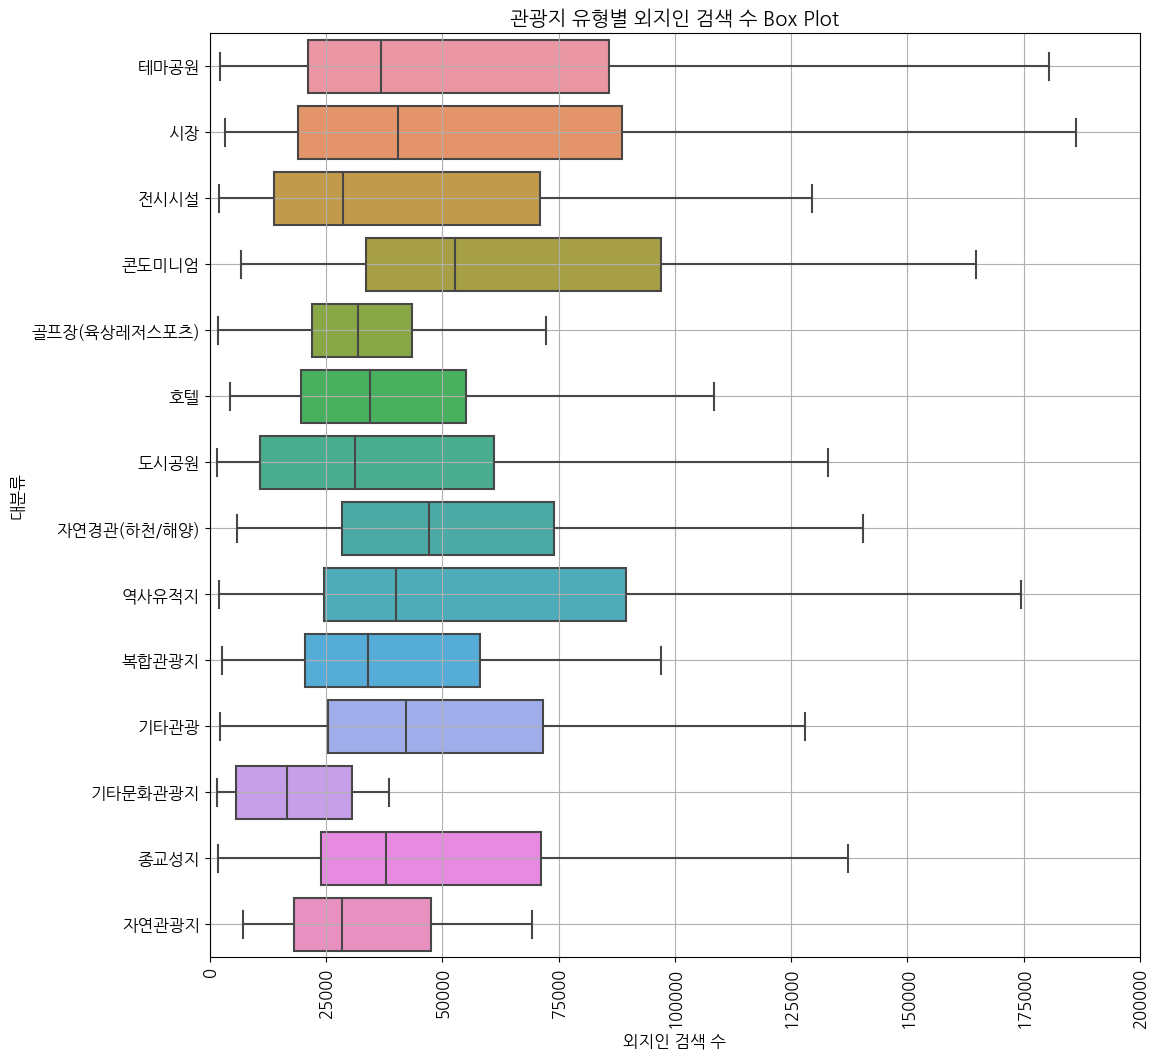

In [ ]:
# 대분류별로 박스플롯 그리기(공연시설 제외)
sorted_data = tour_result.sort_values(by = '외지인 검색 수', ascending = False)
categories = sorted_data['대분류'].unique()

# 그래프 크기 설정
plt.figure(figsize=(12, 12))

# 대분류별로 박스플롯 그리기
sns.boxplot(data=sorted_data[sorted_data['대분류'].isin(categories)], x='외지인 검색 수', y='대분류', showfliers=False)
plt.xticks(rotation=90)
plt.xlabel('외지인 검색 수')
plt.ylabel('대분류')
plt.title('관광지 유형별 외지인 검색 수 Box Plot')
plt.xlim(0,200000)
plt.grid()
plt.savefig('관광지 유형별 외지인 검색 수.png')
plt.show()

## 3-2) 관광유형 분석

### T-Test

### 관광 유형별로 t검정

In [ ]:
# 관광 유형별로 t검정

# 관광 유형 개수 세기 - 가장 적은 유형이 29개
t_category = []
not_category = []
category = tour_result['대분류'].unique()
for i in category:
    print(f'{i} 유형 개수 : {len(tour_result.loc[tour_result["대분류"]==i])}')
    if len(tour_result.loc[tour_result["대분류"]==i]) > 25:
        t_category.append(i)
    else:
        not_category.append(i)
        not_category.append(len(tour_result.loc[tour_result["대분류"]==i]))

시장 유형 개수 : 113
콘도미니엄 유형 개수 : 64
호텔 유형 개수 : 143
자연경관(하천/해양) 유형 개수 : 117
테마공원 유형 개수 : 60
골프장(육상레저스포츠) 유형 개수 : 139
기타문화관광지 유형 개수 : 29
종교성지 유형 개수 : 56
기타관광 유형 개수 : 73
복합관광지 유형 개수 : 65
역사유적지 유형 개수 : 41
자연관광지 유형 개수 : 43
전시시설 유형 개수 : 74
도시공원 유형 개수 : 85


In [ ]:
# 정규성 검정
n_list = []
t_list = []
for i in category:
    #print(i)
    result = stats.shapiro(tour_result.loc[tour_result['대분류']== i, '외지인 검색 수'])
    if result.pvalue < 0.05: # 유의수준 0.05 # 귀무가설 : 정규분포를 따른다. 대립가설 : 정규분포를 따르지 않는다.
        #print(f'{i}는 정규분포를 따르지 않습니다.')
        t_list.append(i)
    else:
        #print(f'{i}는 정규분포를 따릅니다.')
        n_list.append(i)
    #print()

print(f'정규분포를 따르는 관광 유형 : {n_list}', '\n',len(n_list), '개')
print(f'정규분포를 따르지 않는 관광 유형 : {t_list}', '\n', len(t_list), '개')

정규분포를 따르는 관광 유형 : [] 
 0 개
정규분포를 따르지 않는 관광 유형 : ['시장', '콘도미니엄', '호텔', '자연경관(하천/해양)', '테마공원', '골프장(육상레저스포츠)', '기타문화관광지', '종교성지', '기타관광', '복합관광지', '역사유적지', '자연관광지', '전시시설', '도시공원'] 
 14 개


### 양측검정

In [ ]:
from scipy import stats

for i in t_category:
    print(f'<{i}>')
    group1 = tour_result.loc[tour_result["대분류"]==i, '외지인 검색 수']
    for j in t_category:
        group2 = tour_result.loc[tour_result["대분류"]==j, '외지인 검색 수']
        # 등분산 검정
        statistic, p_value = stats.levene(group1, group2)

        # 유의수준 0.05로 검정
        if p_value < 0.05:
#             print("두 집단은 이분산을 가정할 수 있습니다.")
            t_stat, p_value_t = stats.ttest_ind(group1, group2, equal_var=False, alternative='two-sided')
        else:
#             print("두 집단은 등분산을 가정할 수 있습니다.")
            t_stat, p_value_t = stats.ttest_ind(group1, group2, equal_var=True, alternative='two-sided')

        if p_value_t < 0.05:
            print(f'{i} != {j}', end = ' ')
            print(f'p값 : {p_value_t}')
#         else:
#             print(f'{i} == {j}')
    print('-----------------------------------------------')

<시장>
시장 != 호텔 p값 : 0.016131720858414657
시장 != 골프장(육상레저스포츠) p값 : 0.003950125310557715
시장 != 기타문화관광지 p값 : 0.01910859094087986
시장 != 기타관광 p값 : 0.03365843132186239
시장 != 복합관광지 p값 : 0.01643624341501741
시장 != 자연관광지 p값 : 0.0007411017325192008
-----------------------------------------------
<콘도미니엄>
콘도미니엄 != 호텔 p값 : 0.015141112255686512
콘도미니엄 != 골프장(육상레저스포츠) p값 : 0.004320630505564653
콘도미니엄 != 기타문화관광지 p값 : 0.0035625904546696483
콘도미니엄 != 종교성지 p값 : 0.04161943223569417
콘도미니엄 != 기타관광 p값 : 0.021718164630885873
콘도미니엄 != 복합관광지 p값 : 0.013975546462704384
콘도미니엄 != 자연관광지 p값 : 0.0009795478094551642
콘도미니엄 != 도시공원 p값 : 0.04399655169623631
-----------------------------------------------
<호텔>
호텔 != 시장 p값 : 0.016131720858414657
호텔 != 콘도미니엄 p값 : 0.015141112255686512
호텔 != 자연경관(하천/해양) p값 : 0.04478307878513641
호텔 != 기타문화관광지 p값 : 0.01522744705051794
-----------------------------------------------
<자연경관(하천/해양)>
자연경관(하천/해양) != 호텔 p값 : 0.04478307878513641
자연경관(하천/해양) != 골프장(육상레저스포츠) p값 : 0.003503375378683525
자연경관(하천/해양

### 단측검정

In [ ]:
# greater
from scipy import stats

for i in t_category:
    print(f'<{i}>')
    group1 = tour_result.loc[tour_result["대분류"]==i, '외지인 검색 수']
    for j in t_category:
        group2 = tour_result.loc[tour_result["대분류"]==j, '외지인 검색 수']
        # 등분산 검정
        statistic, p_value = stats.levene(group1, group2)

        # 유의수준 0.05로 검정
        if p_value < 0.05:
#             print("두 집단은 이분산을 가정할 수 있습니다.")
            t_stat, p_value_t = stats.ttest_ind(group1, group2, equal_var=False, alternative='greater')
        else:
#             print("두 집단은 등분산을 가정할 수 있습니다.")
            t_stat, p_value_t = stats.ttest_ind(group1, group2, equal_var=True, alternative='greater')

        if p_value_t < 0.05:
            print(f'{i} >> {j}', end = ' ')
            print(f'p값 : {p_value_t}')
#         else:
#             print(f'{i} == {j}')
    print('-----------------------------------------------')

<시장>
시장 >> 호텔 p값 : 0.008065860429207329
시장 >> 골프장(육상레저스포츠) p값 : 0.0019750626552788573
시장 >> 기타문화관광지 p값 : 0.00955429547043993
시장 >> 기타관광 p값 : 0.016829215660931197
시장 >> 복합관광지 p값 : 0.008218121707508705
시장 >> 자연관광지 p값 : 0.0003705508662596004
시장 >> 도시공원 p값 : 0.045054792452584896
-----------------------------------------------
<콘도미니엄>
콘도미니엄 >> 호텔 p값 : 0.007570556127843256
콘도미니엄 >> 자연경관(하천/해양) p값 : 0.047778293287985996
콘도미니엄 >> 골프장(육상레저스포츠) p값 : 0.0021603152527823266
콘도미니엄 >> 기타문화관광지 p값 : 0.0017812952273348242
콘도미니엄 >> 종교성지 p값 : 0.020809716117847085
콘도미니엄 >> 기타관광 p값 : 0.010859082315442936
콘도미니엄 >> 복합관광지 p값 : 0.006987773231352192
콘도미니엄 >> 자연관광지 p값 : 0.0004897739047275821
콘도미니엄 >> 도시공원 p값 : 0.021998275848118157
-----------------------------------------------
<호텔>
호텔 >> 기타문화관광지 p값 : 0.00761372352525897
-----------------------------------------------
<자연경관(하천/해양)>
자연경관(하천/해양) >> 호텔 p값 : 0.022391539392568206
자연경관(하천/해양) >> 골프장(육상레저스포츠) p값 : 0.0017516876893417625
자연경관(하천/해양) >> 기타문화관광지 p값 : 0.0003

## 3-3) 관광지 수 분석

### t-test

In [ ]:
# 표본 수가 30이상이 되도록 설정
# 1) 1개/2개/3-4개 => 1개 = 2개
# 2) 2개/3-4개/5-7개/8~18개 => <<<
group1 = general_tour_popu.loc[(general_tour_popu['관광지 수'] >= 1) & (general_tour_popu['관광지 수'] <= 1), '외지인 검색 수']
group2 = general_tour_popu.loc[(general_tour_popu['관광지 수'] >= 2) & (general_tour_popu['관광지 수'] <= 2), '외지인 검색 수']
group3 = general_tour_popu.loc[(general_tour_popu['관광지 수'] >= 3) & (general_tour_popu['관광지 수'] <= 4), '외지인 검색 수']
group4 = general_tour_popu.loc[(general_tour_popu['관광지 수'] >= 5) & (general_tour_popu['관광지 수'] <= 8), '외지인 검색 수']
group5 = general_tour_popu.loc[(general_tour_popu['관광지 수'] >= 9), '외지인 검색 수']


print(f'group1의 행 개수 : {len(group1)}\ngroup2의 행 개수 : {len(group2)}\ngroup3의 행 개수 : {len(group3)}')
print(f'group4의 행 개수 : {len(group4)}\ngroup5의 행 개수 : {len(group5)}')
# 등분산/이분산 검정
def equal_var(group1, group2):
    statistic, p_value = stats.levene(group1, group2)
    if p_value < 0.05:
        print('이분산')
    else:
        print('등분산')

equal_var(group1,group2)
equal_var(group2,group3)
equal_var(group3,group4)
equal_var(group4,group5)

group1의 행 개수 : 35
group2의 행 개수 : 32
group3의 행 개수 : 42
group4의 행 개수 : 40
group5의 행 개수 : 34
등분산
등분산
등분산
이분산


In [ ]:
# 관광지 수에 따른 t검정
# group1, group2
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=True, alternative='less')
print(f'p값 : {p_value}')
if p_value < 0.05:
    print('group1의 외지인 검색 수가 group2의 외지인 검색 수보다 작다.')
else:
    print('@@group1과 group2의 외지인 검색 수는 유의미한 차이가 없다')

# group2, group3
t_stat, p_value = stats.ttest_ind(group2, group3, equal_var=True, alternative='less')
print(f'p값 : {p_value}')
if p_value < 0.05:
    print('group2의 외지인 검색 수가 group3의 외지인 검색 수보다 작다.')
else:
    print('@@group1과 group3의 외지인 검색 수는 유의미한 차이가 없다')

# group3, group4
t_stat, p_value = stats.ttest_ind(group3, group4, equal_var=True, alternative='less')
print(f'p값 : {p_value}')
if p_value < 0.05:
    print('group3의 외지인 검색 수가 group4의 외지인 검색 수보다 작다.')
else:
    print('@@group3과 group4의 외지인 검색 수는 유의미한 차이가 없다')

# group4, group5
t_stat, p_value = stats.ttest_ind(group4, group5, equal_var=False, alternative='less')
print(f'p값 : {p_value}')
if p_value < 0.05:
    print('group4의 외지인 검색 수가 group5의 외지인 검색 수보다 작다.')
else:
    print('@@group2과 group3의 외지인 검색 수는 유의미한 차이가 없다')

p값 : 0.06686929486344197
@@group1과 group2의 외지인 검색 수는 유의미한 차이가 없다
p값 : 0.013438616472535426
group2의 외지인 검색 수가 group3의 외지인 검색 수보다 작다.
p값 : 0.04550106850217111
group3의 외지인 검색 수가 group4의 외지인 검색 수보다 작다.
p값 : 0.00013619088546697842
group4의 외지인 검색 수가 group5의 외지인 검색 수보다 작다.


### BoxPlot

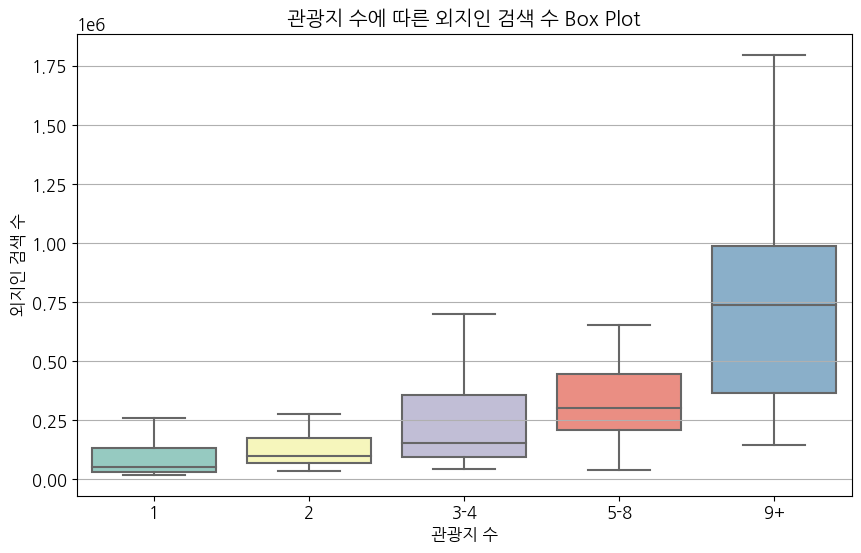

In [ ]:
# 관광지 수 group별로 박스플롯 그리기

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 5개 그룹의 데이터로 박스플롯 그리기
sns.boxplot(data=[group1, group2, group3, group4, group5],
            showfliers=False,  # 이상치 제외
            notch=False,        # 신뢰구간 표시
            palette='Set3')

# 그래프 설정
plt.xlabel('관광지 수')
plt.ylabel('외지인 검색 수')
plt.title('관광지 수에 따른 외지인 검색 수 Box Plot')
plt.xticks([0, 1, 2, 3, 4], ['1', '2', '3-4', '5-8', '9+'])
plt.grid(axis='y')

# 그래프 출력
plt.savefig('관광지 수에 따른 외지인 검색 수.png')
plt.show()


In [ ]:
# categories #'테마공원', '시장', '전시시설', '콘도미니엄', '골프장(육상레저스포츠)', '호텔', '도시공원',
#        '자연경관(하천/해양)', '역사유적지', '복합관광지', '기타관광', '기타문화관광지', '종교성지',
#        '자연관광지'
mean_dict = {}
for k in categories:
    print(f'관광지 유형 : {k}')
    mean = tour_result.loc[tour_result['대분류'] == k,'외지인 검색 수'].mean()
    mean_dict[k] = mean
mean_dict

관광지 유형 : 테마공원
관광지 유형 : 시장
관광지 유형 : 전시시설
관광지 유형 : 콘도미니엄
관광지 유형 : 골프장(육상레저스포츠)
관광지 유형 : 호텔
관광지 유형 : 도시공원
관광지 유형 : 자연경관(하천/해양)
관광지 유형 : 역사유적지
관광지 유형 : 복합관광지
관광지 유형 : 기타관광
관광지 유형 : 기타문화관광지
관광지 유형 : 종교성지
관광지 유형 : 자연관광지


{'테마공원': 77347.55,
 '시장': 81502.77876106194,
 '전시시설': 63061.90540540541,
 '콘도미니엄': 84590.5,
 '골프장(육상레저스포츠)': 44726.74820143885,
 '호텔': 50653.66433566433,
 '도시공원': 55570.24705882353,
 '자연경관(하천/해양)': 64540.05128205128,
 '역사유적지': 66389.60975609756,
 '복합관광지': 49413.56923076923,
 '기타관광': 53908.57534246575,
 '기타문화관광지': 25143.103448275862,
 '종교성지': 53827.142857142855,
 '자연관광지': 37627.6976744186}

In [ ]:
# value 값을 기준으로 내림차순으로 정렬
sorted_data = {k: v for k, v in sorted(mean_dict.items(), key=lambda item: item[1], reverse=True)}

print(sorted_data)
# mean 기준
# 콘도미니엄 > 시장 > 테마공원 > 역사유적지 > 자연경관(하천/해양) > 전시시설 > 도시공원 > 기타관광 > 종교성지 > 호텔 > 복합관광지 > 골프장 > 자연관광지 > 기타문화관광지

{'콘도미니엄': 84590.5, '시장': 81502.77876106194, '테마공원': 77347.55, '역사유적지': 66389.60975609756, '자연경관(하천/해양)': 64540.05128205128, '전시시설': 63061.90540540541, '도시공원': 55570.24705882353, '기타관광': 53908.57534246575, '종교성지': 53827.142857142855, '호텔': 50653.66433566433, '복합관광지': 49413.56923076923, '골프장(육상레저스포츠)': 44726.74820143885, '자연관광지': 37627.6976744186, '기타문화관광지': 25143.103448275862}


In [ ]:
# categories #'테마공원', '시장', '전시시설', '콘도미니엄', '골프장(육상레저스포츠)', '호텔', '도시공원',
#        '자연경관(하천/해양)', '역사유적지', '복합관광지', '기타관광', '기타문화관광지', '종교성지',
#        '자연관광지'
median_dict = {}
for k in categories:
    print(f'관광지 유형 : {k}')
    median = tour_result.loc[tour_result['대분류'] == k,'외지인 검색 수'].median()
    median_dict[k] = median
median_dict

관광지 유형 : 테마공원
관광지 유형 : 시장
관광지 유형 : 전시시설
관광지 유형 : 콘도미니엄
관광지 유형 : 골프장(육상레저스포츠)
관광지 유형 : 호텔
관광지 유형 : 도시공원
관광지 유형 : 자연경관(하천/해양)
관광지 유형 : 역사유적지
관광지 유형 : 복합관광지
관광지 유형 : 기타관광
관광지 유형 : 기타문화관광지
관광지 유형 : 종교성지
관광지 유형 : 자연관광지


{'테마공원': 36771.5,
 '시장': 40438.0,
 '전시시설': 28754.0,
 '콘도미니엄': 52750.0,
 '골프장(육상레저스포츠)': 31786.0,
 '호텔': 34404.0,
 '도시공원': 31293.0,
 '자연경관(하천/해양)': 47243.0,
 '역사유적지': 40007.0,
 '복합관광지': 34037.0,
 '기타관광': 42204.0,
 '기타문화관광지': 16538.0,
 '종교성지': 37910.5,
 '자연관광지': 28363.0}

In [ ]:
# value 값을 기준으로 내림차순으로 정렬
sorted_data = {k: v for k, v in sorted(median_dict.items(), key=lambda item: item[1], reverse=True)}

print(sorted_data)
# median 기준
# 콘도미니엄 > 자연경관(하천/해양) > 기타관광 > 시장 > 역사유적지 > 종교성지 > 테마공원 > 호텔 > 복합관광지 > 골프장(육상레저스포츠) > 도시공원 > 전시시설 > 자연관광지 > 기타문화관광지

{'콘도미니엄': 52750.0, '자연경관(하천/해양)': 47243.0, '기타관광': 42204.0, '시장': 40438.0, '역사유적지': 40007.0, '종교성지': 37910.5, '테마공원': 36771.5, '호텔': 34404.0, '복합관광지': 34037.0, '골프장(육상레저스포츠)': 31786.0, '도시공원': 31293.0, '전시시설': 28754.0, '자연관광지': 28363.0, '기타문화관광지': 16538.0}


In [ ]:
from scipy.stats import pearsonr
not_p_list = []

print('<관광유형과 외지인 검색 수의 피어슨상관분석>\n')
for k in categories:
    # 상관계수 & p-value 계산
    corr_coef, p_value = pearsonr(general_tour_popu[k], general_tour_popu['외지인 검색 수'])

    print(f"{k}과/와 외지인 검색 수의 상관계수:", corr_coef)
    print("p-value:", p_value, "\n")
    if p_value > 0.05:
        not_p_list.append(k)
not_p_list

<관광유형과 외지인 검색 수의 피어슨상관분석>

테마공원과/와 외지인 검색 수의 상관계수: 0.30203377690907496
p-value: 3.248554024619313e-05 

시장과/와 외지인 검색 수의 상관계수: 0.2941550230760564
p-value: 5.3047913279712505e-05 

전시시설과/와 외지인 검색 수의 상관계수: 0.29568568246187593
p-value: 4.828074525889111e-05 

콘도미니엄과/와 외지인 검색 수의 상관계수: 0.6396090373606891
p-value: 1.9286682639422215e-22 

골프장(육상레저스포츠)과/와 외지인 검색 수의 상관계수: 0.21829239350773486
p-value: 0.0029910473490436886 

호텔과/와 외지인 검색 수의 상관계수: 0.5192666963606911
p-value: 5.0247144767568884e-14 

도시공원과/와 외지인 검색 수의 상관계수: 0.13827143518344456
p-value: 0.06194896291643563 

자연경관(하천/해양)과/와 외지인 검색 수의 상관계수: 0.42739414731705105
p-value: 1.5988276794084697e-09 

역사유적지과/와 외지인 검색 수의 상관계수: 0.25134907176929155
p-value: 0.000598803348844395 

복합관광지과/와 외지인 검색 수의 상관계수: 0.4510710901665847
p-value: 1.4738228088524283e-10 

기타관광과/와 외지인 검색 수의 상관계수: 0.2905123770232322
p-value: 6.623082582962576e-05 

기타문화관광지과/와 외지인 검색 수의 상관계수: 0.09093588441116837
p-value: 0.22085158022488277 

종교성지과/와 외지인 검색 수의 상관계수: 0.05471580094

['도시공원', '기타문화관광지', '종교성지']

In [ ]:
general_tour_popu.iloc[:,:-2]

,시도명,시군구명,외지인 검색 수,관광지 수,골프장(육상레저스포츠),기타관광,기타문화관광지,도시공원,복합관광지,시장,역사유적지,자연경관(하천/해양),자연관광지,전시시설,종교성지,콘도미니엄,테마공원,호텔,계
0,강원특별자치도,강릉시,1748289,16,0,0,0,0,2,2,1,5,0,1,0,2,0,3,210456
1,강원특별자치도,고성군,499691,7,1,0,0,0,1,0,0,2,0,0,0,3,0,0,27311
2,강원특별자치도,동해시,122524,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,89058
3,강원특별자치도,삼척시,758197,3,0,0,0,0,0,0,0,2,0,0,0,1,0,0,63270
4,강원특별자치도,속초시,2572437,13,0,2,0,1,1,1,0,3,0,0,0,2,0,3,82474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,충청북도,제천시,515253,12,2,2,0,0,1,1,1,1,0,0,0,3,0,1,131231
179,충청북도,증평군,32306,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,37349
180,충청북도,진천군,223976,6,5,0,0,0,0,0,1,0,0,0,0,0,0,0,85876
181,충청북도,청주시,584236,15,4,1,0,2,1,2,1,0,0,1,0,0,1,2,850168


## 4. 외지인 검색 수와 총 방문자수 상관관계 및 t검정

In [ ]:
df = pd.read_csv('/Users/bagtaejeong/Desktop/DSL/EDA/관광/데이터/CB_merged_df.csv')

search_group = df['외지인 검색 수'] #209
visit_group = df['총계'] #209

In [ ]:
corr_coef, p_value = pearsonr(search_group, visit_group)

print(f"총 방문자 수와 외지인 검색 수의 상관계수:", corr_coef)
print("p-value:", p_value)

총 방문자 수와 외지인 검색 수의 상관계수: 0.6443457510604329
p-value: 6.578393568855331e-26


In [ ]:
# t-test

# 등분산 검정
statistic, p_value = stats.levene(search_group, visit_group)

# 유의수준 0.05로 검정
if p_value < 0.05:
    t_stat, p_value_t = stats.ttest_ind(group1, group2, equal_var=False, alternative='two-sided')
else:
    t_stat, p_value_t = stats.ttest_ind(group1, group2, equal_var=True, alternative='two-sided')

if p_value_t < 0.05:
    print('외지인 검색 수와 총 방문자 수의 평균은 다르다.')
    print(f'p값 : {p_value_t}')

else:
    print('외지인 검색 수와 총 방문자 수의 평균은 같다.')
    print(f'p값 : {p_value_t}')

외지인 검색 수와 총 방문자 수의 평균은 같다.
p값 : 0.1364135996927888
